## Sanity check: SNV counts and substitution probabilities are consistent

Are our estimated substitution probabilities consistent with 
the SNV counts per genomic window that we independently obtain during training? 

To answer that question, we assume the following generative model. 
Imagine scanning each site in a window, 
and determining whether to generate an SNV at each site by 
first sampling a single-ALT substitution probability from a beta distribution, 
and then substituting with that probability. 
Therefore the number of SNVs per window is a random draw from a beta-binomial distribution. 
Fitting a beta-binomial distribution to the observed distribution of SNV counts per window
yields estimates for the parameters of the beta distribution. 
Finally, we compare the estimated beta distribution with
the observed distribution of substitution probabilities 
estimated elsewhere during training. 

The results (below) show that the SNV counts per window and the estimated substitution probabilities 
are broadly consistent, allowing us to conclude that there aren't any major data or code 
issues. 

In particular, this is true even when Heng Li's Low Complexity Regions (LCRs) are included in the analysis
(see below). 
Though these regions are well known to be enriched for false positive SNVs
(https://academic.oup.com/bioinformatics/article/30/20/2843/2422145),
it appears that they don't significantly affect estimation of substitution probabilities or 
the distribution of SNV counts per window. 
This may be because true positive SNVs far outnumber false positive SNVs. 

In [14]:
import matplotlib.pyplot as plt 
from scipy import stats 
import numpy as np 

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

from kmer import compute_possible_ALT_states_core 
from read_model import read_model

def get_substitution_probabilities(model): 
  kmer_probabilities = model['kmerProbabilities']
  single_alt_substitution_probabilities = []
  for kmer, probabilities in kmer_probabilities.items():
    single_alt_substitution_probabilities.append(
      sum(probabilities[alt_state] for alt_state in compute_possible_ALT_states_core(kmer, ALT_multiplicity=1))
    )
  return np.array(single_alt_substitution_probabilities)

def get_observed_snvCounts_windowCounts(model): 
  snv_counts, window_counts = zip(*[
    (snv_count, sum(singleton_counts)) 
    for snv_count, singleton_counts in model['singletonCounts'].items()
  ])
  snv_counts, window_counts = zip(*sorted(zip(snv_counts, window_counts), key=lambda pair: pair[0]))
  return snv_counts, window_counts

def get_window_total_counts(model): 
  _, window_counts_observed = get_observed_snvCounts_windowCounts(model)
  return sum(window_counts_observed)

def fit_beta_binomial(model, snv_counts_observed, window_counts_observed): 
  n = model['windowSize']
  def func(x, a, b):
    return get_window_total_counts(model) * stats.betabinom(n, a, b).pmf(x)
  from scipy.optimize import curve_fit
  estimated_parameters, _ = curve_fit(
    f = func, 
    xdata = snv_counts_observed, 
    ydata = window_counts_observed, 
    bounds = (0.01, [1000, 1000])
  )
  snv_counts_multinomial = range(1, 3*model['windowSize'])
  # Each window can be categorized according to the number of SNVs it contains.
  # The probability of each category is beta-binomial. 
  # Therefore, the number of windows in each category is multinomial, 
  # with categorical probabilities equal to the corresponding beta-binomial probabilities.
  category_probabilities = stats.betabinom(n, *estimated_parameters).pmf(snv_counts_multinomial)
  window_counts_mean_multinomial = get_window_total_counts(model) * category_probabilities
  window_counts_variance_multinomial = get_window_total_counts(model) * category_probabilities * (1 - category_probabilities)
  window_counts_std_multinomial = np.sqrt(window_counts_variance_multinomial)
  return snv_counts_multinomial, window_counts_mean_multinomial, window_counts_std_multinomial, estimated_parameters

def plot_snvCountDistribution_substitutionProbabilityDistribution(model_filename):
  model = read_model(model_filename)
  snv_counts_observed, window_counts_observed = get_observed_snvCounts_windowCounts(model)
  (
    snv_counts_multinomial, 
    window_counts_mean_multinomial, 
    window_counts_std_multinomial, 
    estimated_parameters
  ) = fit_beta_binomial(model, snv_counts_observed, window_counts_observed)

  # plot snv count distribution 
  plt.rcParams.update({'font.size': 20})
  fig = plt.figure()
  fig.set_size_inches(12, 12)  
  axis = fig.add_subplot()
  axis.scatter(snv_counts_observed, window_counts_observed, label='observed')
  axis.plot(
    snv_counts_multinomial, 
    window_counts_mean_multinomial, 
    linestyle='-', 
    marker=None, 
    color='red', 
    label='mean of multinomial'
  )
  axis.fill_between(
    snv_counts_multinomial, 
    window_counts_mean_multinomial - window_counts_std_multinomial, 
    window_counts_mean_multinomial + window_counts_std_multinomial, 
    color='red', 
    alpha=.1,
    label='+- standard deviation of multinomial'
  )
  axis.set_xscale('log')
  axis.set_yscale('log')
  axis.set_xlabel(f"number of SNVs in {model['windowSize']}bp window")
  axis.set_ylabel(f"number of {model['windowSize']}bp windows")
  plt.grid(which='major')
  axis.set_xlim([1, 1e3])
  axis.set_ylim([1, 1e7])
  axis.legend()
  axis.set_title('non-coding genome')

  # plot substitution probability distribution 
  x = np.arange(0, 1, 0.001)
  plt.rcParams.update({'font.size': 20})
  fig = plt.figure()
  fig.set_size_inches(12, 6)  
  axis = fig.add_subplot()
  a, b = estimated_parameters
  axis.plot(x, stats.beta(a, b).pdf(x), 'k-', lw=2, label='beta pdf (fit using SNV counts per window)')
  axis.hist(
    get_substitution_probabilities(model), 
    density=True, 
    histtype='stepfilled', 
    alpha=0.2, 
    label='observed (scaled to unit area)', 
    bins=100
  )
  axis.set_xlabel('probability of substituting a single ALT allele')
  # axis.set_yscale('log')
  # axis.set_ylim([1e-3, 1e2])
  axis.legend()



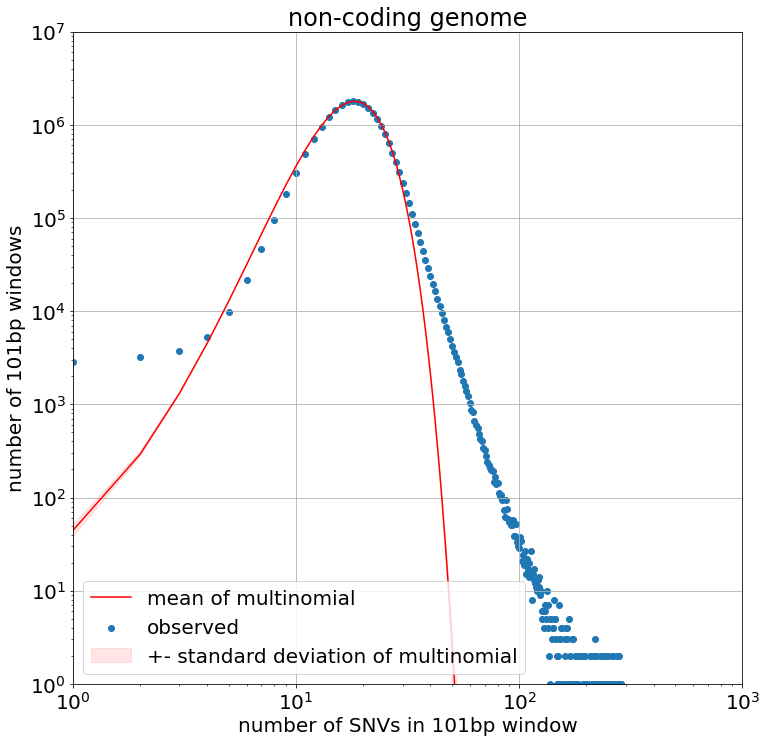

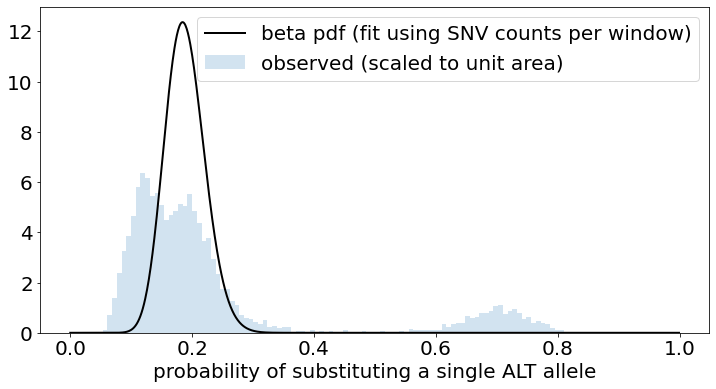

In [15]:
# all neutral regions: 
plot_snvCountDistribution_substitutionProbabilityDistribution(
  model_filename = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'
)

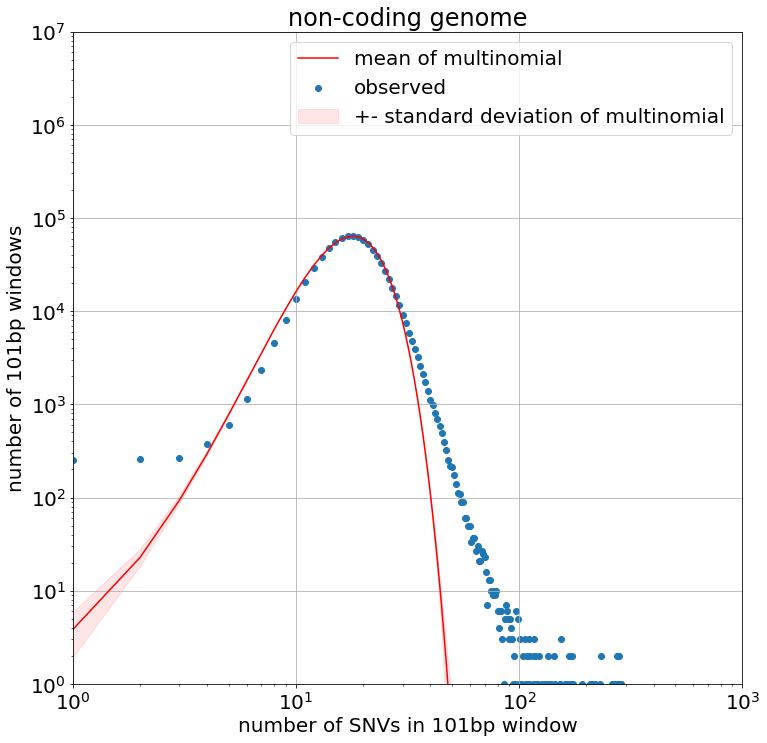

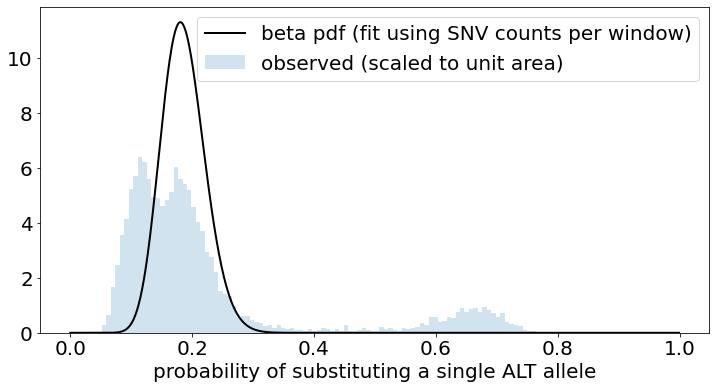

In [16]:
# neutral regions less Heng Li's Low Complexity Regions: 
plot_snvCountDistribution_substitutionProbabilityDistribution(
  model_filename = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/experiments/exclude-regions/exclude-li-low-complexity-regions/model-germline-grch38.json'
)